# Forecastng Fuel Pricing

# Importanto as bibliotecas

In [1]:
%config IPCompleter.greedy=True #Autocomplete

import pandas as pd #Importar pandas
import sklearn as skt
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Ridge
from sklearn import svm
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns

pd.options.mode.chained_assignment = None

# Importanto os dados
Primeiramente, os dados contidos no tsv precisam ser importatos para serem utilizados no processo, os mesmo também precisam ser unidos em um *dataframe* único

In [2]:
df1 = pd.read_csv('./gas-prices-in-brazil/2004-2012.tsv',sep='\t', header=0)
df2 = pd.read_csv('./gas-prices-in-brazil/2013-2019.tsv',sep='\t', header=0)

In [3]:
df = df1.append(df2, ignore_index=True)
df.head(5)

,DATA INICIAL,DATA FINAL,REGIÃO,ESTADO,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO,ANO,MÊS
0,09/05/2004,15/05/2004,CENTRO OESTE,DISTRITO FEDERAL,ETANOL HIDRATADO,127,R$/l,1288.0,16,1.19,1.35,463,12,825,0.11,0.4201,0.9666,133,2004,5
1,09/05/2004,15/05/2004,CENTRO OESTE,GOIAS,ETANOL HIDRATADO,387,R$/l,1162.0,114,0.89,1449,399,98,763,88,0.5013,1.05,115,2004,5
2,09/05/2004,15/05/2004,CENTRO OESTE,MATO GROSSO,ETANOL HIDRATADO,192,R$/l,1389.0,97,1.18,1.76,419,0.07,0.97,95,0.5614,1161,98,2004,5
3,09/05/2004,15/05/2004,CENTRO OESTE,MATO GROSSO DO SUL,ETANOL HIDRATADO,162,R$/l,1262.0,0.07,1.09,1509,432,55,0.83,119,0.5991,1.22242,143,2004,5
4,09/05/2004,15/05/2004,NORDESTE,ALAGOAS,ETANOL HIDRATADO,103,R$/l,1181.0,78,1.05,1.4,0.24,66,941,77,0.7441,1.0317,82,2004,5


In [4]:
list(df.columns)

['DATA INICIAL',
 'DATA FINAL',
 'REGIÃO',
 'ESTADO',
 'PRODUTO',
 'NÚMERO DE POSTOS PESQUISADOS',
 'UNIDADE DE MEDIDA',
 'PREÇO MÉDIO REVENDA',
 'DESVIO PADRÃO REVENDA',
 'PREÇO MÍNIMO REVENDA',
 'PREÇO MÁXIMO REVENDA',
 'MARGEM MÉDIA REVENDA',
 'COEF DE VARIAÇÃO REVENDA',
 'PREÇO MÉDIO DISTRIBUIÇÃO',
 'DESVIO PADRÃO DISTRIBUIÇÃO',
 'PREÇO MÍNIMO DISTRIBUIÇÃO',
 'PREÇO MÁXIMO DISTRIBUIÇÃO',
 'COEF DE VARIAÇÃO DISTRIBUIÇÃO',
 'ANO',
 'MÊS']

# Separando os dados
A seguir apenas os dados relevantes são mantidos para o modelo de regressão

In [5]:
df_separation = df.drop(["NÚMERO DE POSTOS PESQUISADOS","UNIDADE DE MEDIDA", "DATA FINAL", "ANO", "MÊS"],axis=1)


In [6]:
df_separation = df_separation[df_separation["PRODUTO"]=="GASOLINA COMUM"]

In [7]:
df_separation.head()

,DATA INICIAL,REGIÃO,ESTADO,PRODUTO,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO
12064,09/05/2004,CENTRO OESTE,DISTRITO FEDERAL,GASOLINA COMUM,2029.00,7,1.99,2.07,318,3,1711,0.02,1651,1.7427,12
12065,09/05/2004,CENTRO OESTE,GOIAS,GASOLINA COMUM,2025.00,62,1.85,2.22,296,31,1729,36,1.6643,1915,21
12066,09/05/2004,CENTRO OESTE,MATO GROSSO,GASOLINA COMUM,2358.00,66,2,2.54,472,28,1886,68,1.75,2.0713,36
12067,09/05/2004,CENTRO OESTE,MATO GROSSO DO SUL,GASOLINA COMUM,2.12,75,1.97,2.44,325,35,1795,33,1.70701,1.9703,18
12068,09/05/2004,NORDESTE,ALAGOAS,GASOLINA COMUM,2.09,34,2,2159,0.35,16,1.74,42,1.6789,1918,24


# Tratamento de dados
Os dados a seguir são convertidos para tipos que podem ser utilizados nos modelos de regressão.  Os dados do tipo *string* são modificados para valores númericos, como não existe correlação direta entre os dados e os valores a distribuição é feita na ordem que aparecem, por exemplo, o Estado não tem coreelação direta com o valor, portanto, apenas uma lista númerica é aplicada ao mesmo

In [8]:
# c = df["REGIÃO"].astype("category")
# d = dict(enumerate(c.cat.categories))
# print(d)
df_separation["REGIÃO"] = df_separation["REGIÃO"].astype("category").cat.codes
df_separation.head()

,DATA INICIAL,REGIÃO,ESTADO,PRODUTO,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO
12064,09/05/2004,0,DISTRITO FEDERAL,GASOLINA COMUM,2029.00,7,1.99,2.07,318,3,1711,0.02,1651,1.7427,12
12065,09/05/2004,0,GOIAS,GASOLINA COMUM,2025.00,62,1.85,2.22,296,31,1729,36,1.6643,1915,21
12066,09/05/2004,0,MATO GROSSO,GASOLINA COMUM,2358.00,66,2,2.54,472,28,1886,68,1.75,2.0713,36
12067,09/05/2004,0,MATO GROSSO DO SUL,GASOLINA COMUM,2.12,75,1.97,2.44,325,35,1795,33,1.70701,1.9703,18
12068,09/05/2004,1,ALAGOAS,GASOLINA COMUM,2.09,34,2,2159,0.35,16,1.74,42,1.6789,1918,24


In [9]:
c = df_separation["ESTADO"].astype("category")
d = dict(enumerate(c.cat.categories))
print(d)
df_separation["ESTADO"] = df_separation["ESTADO"].astype("category").cat.codes
df_separation.head()

{0: 'ACRE', 1: 'ALAGOAS', 2: 'AMAPA', 3: 'AMAZONAS', 4: 'BAHIA', 5: 'CEARA', 6: 'DISTRITO FEDERAL', 7: 'ESPIRITO SANTO', 8: 'GOIAS', 9: 'MARANHAO', 10: 'MATO GROSSO', 11: 'MATO GROSSO DO SUL', 12: 'MINAS GERAIS', 13: 'PARA', 14: 'PARAIBA', 15: 'PARANA', 16: 'PERNAMBUCO', 17: 'PIAUI', 18: 'RIO DE JANEIRO', 19: 'RIO GRANDE DO NORTE', 20: 'RIO GRANDE DO SUL', 21: 'RONDONIA', 22: 'RORAIMA', 23: 'SANTA CATARINA', 24: 'SAO PAULO', 25: 'SERGIPE', 26: 'TOCANTINS'}


,DATA INICIAL,REGIÃO,ESTADO,PRODUTO,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO
12064,09/05/2004,0,6,GASOLINA COMUM,2029.00,7,1.99,2.07,318,3,1711,0.02,1651,1.7427,12
12065,09/05/2004,0,8,GASOLINA COMUM,2025.00,62,1.85,2.22,296,31,1729,36,1.6643,1915,21
12066,09/05/2004,0,10,GASOLINA COMUM,2358.00,66,2,2.54,472,28,1886,68,1.75,2.0713,36
12067,09/05/2004,0,11,GASOLINA COMUM,2.12,75,1.97,2.44,325,35,1795,33,1.70701,1.9703,18
12068,09/05/2004,1,1,GASOLINA COMUM,2.09,34,2,2159,0.35,16,1.74,42,1.6789,1918,24


In [10]:
df_separation["PREÇO MÉDIO REVENDA"] = df_separation["PREÇO MÉDIO REVENDA"].astype("int32")
df_separation["PREÇO MÉDIO REVENDA"] = df_separation["PREÇO MÉDIO REVENDA"].apply(lambda x: x/1000 if x>10 else x)

In [11]:
df_separation["DESVIO PADRÃO REVENDA"] = df_separation["DESVIO PADRÃO REVENDA"].astype(str)
df_separation = df_separation[df_separation["DESVIO PADRÃO REVENDA"] != "-"]
df_separation["DESVIO PADRÃO REVENDA"] = df_separation["DESVIO PADRÃO REVENDA"].str.replace(',', '.')
df_separation["DESVIO PADRÃO REVENDA"] = df_separation["DESVIO PADRÃO REVENDA"].astype("float")
df_separation["DESVIO PADRÃO REVENDA"] = df_separation["DESVIO PADRÃO REVENDA"].apply(lambda x: x/1000 if x>5 else x)

In [12]:
df_separation["PREÇO MÍNIMO REVENDA"] = df_separation["PREÇO MÍNIMO REVENDA"].astype(str)
df_separation = df_separation[df_separation["PREÇO MÍNIMO REVENDA"] != "-"]
df_separation["PREÇO MÍNIMO REVENDA"] = df_separation["PREÇO MÍNIMO REVENDA"].str.replace(',', '.')
df_separation["PREÇO MÍNIMO REVENDA"] = df_separation["PREÇO MÍNIMO REVENDA"].astype("float")
df_separation["PREÇO MÍNIMO REVENDA"] = df_separation["PREÇO MÍNIMO REVENDA"].apply(lambda x: x/1000 if x>10 else x)

In [13]:
df_separation["PREÇO MÁXIMO REVENDA"] = df_separation["PREÇO MÁXIMO REVENDA"].astype(str)
df_separation = df_separation[df_separation["PREÇO MÁXIMO REVENDA"] != "-"]
df_separation["PREÇO MÁXIMO REVENDA"] = df_separation["PREÇO MÁXIMO REVENDA"].str.replace(',', '.')
df_separation["PREÇO MÁXIMO REVENDA"] = df_separation["PREÇO MÁXIMO REVENDA"].astype("float")
df_separation["PREÇO MÁXIMO REVENDA"] = df_separation["PREÇO MÁXIMO REVENDA"].apply(lambda x: x/1000 if x>10 else x)

In [14]:
df_separation["MARGEM MÉDIA REVENDA"] = df_separation["MARGEM MÉDIA REVENDA"].astype(str)
df_separation = df_separation[df_separation["MARGEM MÉDIA REVENDA"] != "-"]
df_separation["MARGEM MÉDIA REVENDA"] = df_separation["MARGEM MÉDIA REVENDA"].str.replace(',', '.')
df_separation["MARGEM MÉDIA REVENDA"] = df_separation["MARGEM MÉDIA REVENDA"].astype("float")
df_separation["MARGEM MÉDIA REVENDA"] = df_separation["MARGEM MÉDIA REVENDA"].apply(lambda x: x/1000 if x>10 else x)

In [15]:
df_separation["COEF DE VARIAÇÃO REVENDA"] = df_separation["COEF DE VARIAÇÃO REVENDA"].astype(str)
df_separation = df_separation[df_separation["COEF DE VARIAÇÃO REVENDA"] != "-"]
df_separation["COEF DE VARIAÇÃO REVENDA"] = df_separation["COEF DE VARIAÇÃO REVENDA"].str.replace(',', '.')
df_separation["COEF DE VARIAÇÃO REVENDA"] = df_separation["COEF DE VARIAÇÃO REVENDA"].astype("float")
df_separation["COEF DE VARIAÇÃO REVENDA"] = df_separation["COEF DE VARIAÇÃO REVENDA"].apply(lambda x: x/1000 if x>10 else x)

In [16]:
df_separation["PREÇO MÉDIO DISTRIBUIÇÃO"] = df_separation["PREÇO MÉDIO DISTRIBUIÇÃO"].astype(str)
df_separation = df_separation[df_separation["PREÇO MÉDIO DISTRIBUIÇÃO"] != "-"]
df_separation["PREÇO MÉDIO DISTRIBUIÇÃO"] = df_separation["PREÇO MÉDIO DISTRIBUIÇÃO"].str.replace(',', '.')
df_separation["PREÇO MÉDIO DISTRIBUIÇÃO"] = df_separation["PREÇO MÉDIO DISTRIBUIÇÃO"].astype("float")
df_separation["PREÇO MÉDIO DISTRIBUIÇÃO"] = df_separation["PREÇO MÉDIO DISTRIBUIÇÃO"].apply(lambda x: x/1000 if x>10 else x)

In [17]:
df_separation["DESVIO PADRÃO DISTRIBUIÇÃO"] = df_separation["DESVIO PADRÃO DISTRIBUIÇÃO"].astype(str)
df_separation = df_separation[df_separation["DESVIO PADRÃO DISTRIBUIÇÃO"] != "-"]
df_separation["DESVIO PADRÃO DISTRIBUIÇÃO"] = df_separation["DESVIO PADRÃO DISTRIBUIÇÃO"].str.replace(',', '.')
df_separation["DESVIO PADRÃO DISTRIBUIÇÃO"] = df_separation["DESVIO PADRÃO DISTRIBUIÇÃO"].astype("float")
df_separation["DESVIO PADRÃO DISTRIBUIÇÃO"] = df_separation["DESVIO PADRÃO DISTRIBUIÇÃO"].apply(lambda x: x/1000 if x>5 else x)

In [18]:
df_separation["PREÇO MÍNIMO DISTRIBUIÇÃO"] = df_separation["PREÇO MÍNIMO DISTRIBUIÇÃO"].astype(str)
df_separation = df_separation[df_separation["PREÇO MÍNIMO DISTRIBUIÇÃO"] != "-"]
df_separation["PREÇO MÍNIMO DISTRIBUIÇÃO"] = df_separation["PREÇO MÍNIMO DISTRIBUIÇÃO"].str.replace(',', '.')
df_separation["PREÇO MÍNIMO DISTRIBUIÇÃO"] = df_separation["PREÇO MÍNIMO DISTRIBUIÇÃO"].astype("float")
df_separation["PREÇO MÍNIMO DISTRIBUIÇÃO"] = df_separation["PREÇO MÍNIMO DISTRIBUIÇÃO"].apply(lambda x: x/1000 if x>10 else x)

In [19]:
df_separation["PREÇO MÁXIMO DISTRIBUIÇÃO"] = df_separation["PREÇO MÁXIMO DISTRIBUIÇÃO"].astype(str)
df_separation = df_separation[df_separation["PREÇO MÁXIMO DISTRIBUIÇÃO"] != "-"]
df_separation["PREÇO MÁXIMO DISTRIBUIÇÃO"] = df_separation["PREÇO MÁXIMO DISTRIBUIÇÃO"].str.replace(',', '.')
df_separation["PREÇO MÁXIMO DISTRIBUIÇÃO"] = df_separation["PREÇO MÁXIMO DISTRIBUIÇÃO"].astype("float")
df_separation["PREÇO MÁXIMO DISTRIBUIÇÃO"] = df_separation["PREÇO MÁXIMO DISTRIBUIÇÃO"].apply(lambda x: x/1000 if x>10 else x)

In [20]:
df_separation["COEF DE VARIAÇÃO DISTRIBUIÇÃO"] = df_separation["COEF DE VARIAÇÃO DISTRIBUIÇÃO"].astype(str)
df_separation = df_separation[df_separation["COEF DE VARIAÇÃO DISTRIBUIÇÃO"] != "-"]
df_separation["COEF DE VARIAÇÃO DISTRIBUIÇÃO"] = df_separation["COEF DE VARIAÇÃO DISTRIBUIÇÃO"].str.replace(',', '.')
df_separation["COEF DE VARIAÇÃO DISTRIBUIÇÃO"] = df_separation["COEF DE VARIAÇÃO DISTRIBUIÇÃO"].astype("float")
df_separation["COEF DE VARIAÇÃO DISTRIBUIÇÃO"] = df_separation["COEF DE VARIAÇÃO DISTRIBUIÇÃO"].apply(lambda x: x/1000 if x>10 else x)

In [21]:
df_separation["DATA INICIAL"] = pd.to_datetime(df_separation["DATA INICIAL"], infer_datetime_format=True)


In [22]:
df_separation.head()

,DATA INICIAL,REGIÃO,ESTADO,PRODUTO,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO
12064,2004-09-05,0,6,GASOLINA COMUM,2.029,0.007,1.99,2.070,0.318,3.000,1.711,0.020,1.65100,1.7427,0.012
12065,2004-09-05,0,8,GASOLINA COMUM,2.025,0.062,1.85,2.220,0.296,0.031,1.729,0.036,1.66430,1.9150,0.021
12066,2004-09-05,0,10,GASOLINA COMUM,2.358,0.066,2.00,2.540,0.472,0.028,1.886,0.068,1.75000,2.0713,0.036
12067,2004-09-05,0,11,GASOLINA COMUM,2.000,0.075,1.97,2.440,0.325,0.035,1.795,0.033,1.70701,1.9703,0.018
12068,2004-09-05,1,1,GASOLINA COMUM,2.000,0.034,2.00,2.159,0.350,0.016,1.740,0.042,1.67890,1.9180,0.024


# Separando os datas frames
Para um primeiro teste apenas a região susdeste será utilizada

In [23]:
df_sp = df_separation[df_separation["ESTADO"]== 24]

In [24]:
df_sp.set_index("DATA INICIAL",inplace=True)

In [25]:
df_sp.drop("ESTADO",axis=1, inplace=True)

In [26]:
df_sp.drop("REGIÃO",axis=1, inplace=True)

In [27]:
df_sp.drop("PRODUTO",axis=1, inplace=True)

In [28]:
df_sp.head()

,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO
DATA INICIAL,,,,,,,,,,,
2004-09-05,1.891,0.101,1.570,2.399,0.235,0.053,1.656,0.064,1.38,1.9440,0.039
2004-05-16,1.888,0.101,1.540,2.220,0.233,0.053,1.655,0.063,1.38,1.9319,0.038
2004-05-23,1.894,0.095,1.570,2.399,0.234,0.050,1.660,0.065,1.39,1.9291,0.039
2004-05-30,1.912,0.094,1.529,2.199,0.235,0.049,1.677,0.068,1.39,1.9733,0.041
2004-06-06,1.919,0.088,1.580,2.399,0.231,0.046,1.688,0.063,1.41,2.0946,0.037


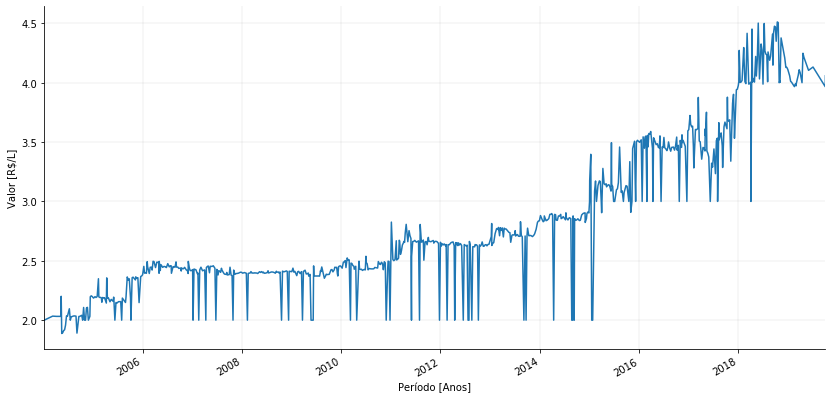

In [29]:
fig, ax = plt.subplots(figsize=(14, 7))
df_sp["PREÇO MÉDIO REVENDA"].plot()
plt.xlabel("Período [Anos]")
plt.ylabel("Valor [R$/L]")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.show()

# Escolhendo as *Features*

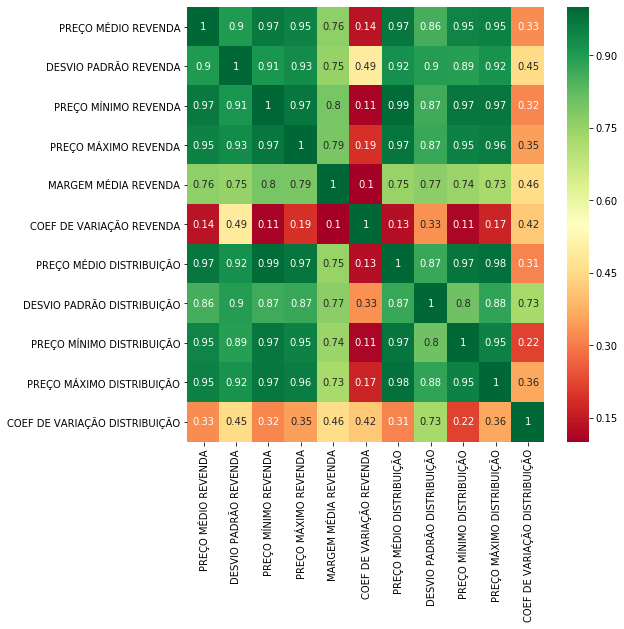

In [30]:

plt.figure(figsize=(8,8))
#plot heat map
g=sns.heatmap(df_sp.corr(),annot=True, cmap="RdYlGn")
# plt.subplots_adjust(bottom=0.28)
plt.show()

In [31]:
# df_sp = df_sp.drop(["COEF DE VARIAÇÃO REVENDA","COEF DE VARIAÇÃO DISTRIBUIÇÃO"], axis=1)

# Separando os valores para treinamento
A seguir os valores serão dividos em *features* e *labels*, sendo x e y as respectivas variáveis a sereum utilizadas para esse processo

In [32]:
df_sp['label'] = df_sp["PREÇO MÉDIO REVENDA"]

In [33]:
x = np.array(df_sp.drop('label', axis=1))
x = preprocessing.normalize(x)
y = np.array(df_sp['label'])

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=0)

In [36]:
x_predc = x[-30:]
df_forecast = df_sp[["PREÇO MÉDIO REVENDA"]][-30:]


### Linear Regreation

In [37]:
rgr = LinearRegression()

In [38]:
rgr.fit(x_train,y_train)
accuracy = rgr.score(x_test, y_test)
scores = cross_val_score(rgr, x, y, cv=5)
forecast_set_linear = rgr.predict(x_predc)
print(accuracy, scores)

0.9646091187396322 [-0.98994371  0.24168181  0.8107551   0.93914985  0.31946944]


In [39]:
df_forecast["Linear Regression"] = forecast_set_linear

### SVR

In [40]:
rgr = svm.SVR(kernel='linear',C=1.0, cache_size=300, coef0=0.0, epsilon=0.1, gamma='scale', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [41]:
rgr.fit(x_train,y_train)
accuracy = rgr.score(x_test, y_test)
scores = cross_val_score(rgr, x, y, cv=5)
forecast_set_SVR_linear = rgr.predict(x_predc)
print(accuracy, scores)

-0.09751590530038667 [ -7.05801467  -8.72982195   0.32191365  -1.40470495 -11.46763522]


In [42]:
df_forecast["SVR kernel=linear"] = forecast_set_SVR_linear

### Ridge

In [43]:
rgr = Ridge()

In [44]:
rgr.fit(x_train,y_train)
accuracy = rgr.score(x_test, y_test)
scores = cross_val_score(rgr, x, y, cv=5)
forecast_set_ridge = rgr.predict(x_predc)
print(accuracy, scores)

0.036890259788052715 [-14.10181703 -20.9719846   -1.74524681  -0.19393586 -10.50018141]


In [45]:
df_forecast["Ridge"] = forecast_set_ridge

### SVR

In [46]:
rgr = svm.SVR(kernel='rbf',C=3, cache_size=200, coef0=0.0, degree=4, epsilon=0.3, gamma='scale', max_iter=-1, shrinking=False, tol=0.01, verbose=False)

In [47]:
rgr.fit(x_train,y_train)
accuracy = rgr.score(x_test, y_test)
scores = cross_val_score(rgr, x, y, cv=5)
forecast_set_SVR_radial = rgr.predict(x_predc)
print(accuracy, scores)

0.13791340863888757 [-18.75051511 -23.55959529   0.20599399  -0.20119431 -10.41824364]


In [48]:
df_forecast["SVR kernel=rbf"] = forecast_set_SVR_radial

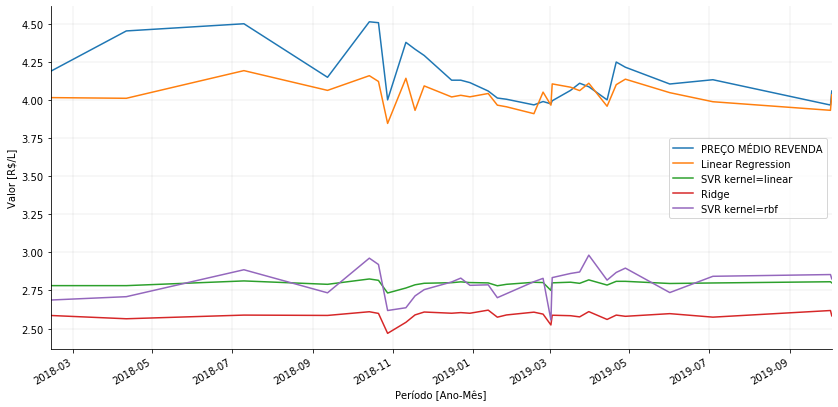

In [49]:
fig, ax = plt.subplots(figsize=(14, 7))
df_forecast["PREÇO MÉDIO REVENDA"].plot()
df_forecast["Linear Regression"].plot()
df_forecast["Ridge"].plot()
df_forecast["SVR kernel=linear"].plot()
df_forecast["SVR kernel=rbf"].plot()
plt.xlabel("Período [Ano-Mês]")
plt.ylabel("Valor [R$/L]")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(df_forecast.columns)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.show()
